In [ ]:
# Importing Necessary Libraries
import os 
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
import pandas as pd
from datetime import datetime
from rasterstats import zonal_stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
SAVED_DATA_PATH = "../data/saved/ndvi.csv"
BAND_MAP = {"B1": 1, "B2": 2, "B3": 3, "B4": 4, "B5": 5, "B6": 6, "B7": 7}

### Extracting Processed NDVI Dataset

In [4]:
def scene_date_from_filename(fname):
    # example LC08_L2SP_141041_20230404_20230412_02_T1_SR_B4.TIF
    m = re.search(r"_(\d{8})_", fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()
    return None

In [5]:
def read_band(band_path):
    with rasterio.open(band_path) as src:
        arr = src.read(1).astype("float32")
        profile = src.profile
    return arr, profile

In [6]:
def compute_ndvi(nir, red):
    np.seterr(divide="ignore", invalid="ignore")
    ndvi = (nir - red) / (nir + red)
    ndvi = np.where(np.isfinite(ndvi), ndvi, np.nan)
    return ndvi

In [7]:
def mean_index_in_aoi(index_arr, profile, aoi_geojson):
    # write index to temporary memfile then use zonal_stats or mask
    stats = zonal_stats(
        aoi_geojson,
        index_arr,
        affine=profile["transform"],
        stats=["mean", "median", "count", "std"],
        nodata=np.nan,
    )
    return stats[0]

In [8]:
def process_scene_folder(scene_folder, aoi_geojson):
    """
    Process a single scene folder to compute NDVI statistics over the AOI.
    Automatically reprojects AOI to match raster CRS.
    """
    # find band files
    b4 = next(p for p in os.listdir(scene_folder) if "_SR_B4" in p)
    b5 = next(p for p in os.listdir(scene_folder) if "_SR_B5" in p)
    b4_arr, prof = read_band(os.path.join(scene_folder, b4))
    b5_arr, _ = read_band(os.path.join(scene_folder, b5))
    ndvi = compute_ndvi(b5_arr, b4_arr)
    scene_date = scene_date_from_filename(b4)

    # Reproject AOI to raster CRS
    gdf = gpd.GeoDataFrame.from_features(aoi_geojson["features"], crs="EPSG:4326")
    gdf_utm = gdf.to_crs(prof["crs"])
    aoi_geojson_utm = gdf_utm.__geo_interface__

    stats = mean_index_in_aoi(ndvi, prof, aoi_geojson_utm)
    return {
        "date": scene_date,
        "ndvi_mean": stats["mean"],
        "ndvi_median": stats["median"],
        "count": stats["count"],
        "ndvi_std": stats["std"],
    }

In [9]:
def build_timeseries(data_root, aoi_geojson):
    """
    Build NDVI timeseries for all scenes in data_root.
    """
    rows = []
    for year in os.listdir(data_root):
        ypath = os.path.join(data_root, year)
        if not os.path.isdir(ypath):
            continue
        for month in os.listdir(ypath):
            mpath = os.path.join(ypath, month)
            if not os.path.isdir(mpath):
                continue
            try:
                r = process_scene_folder(mpath, aoi_geojson)
                rows.append(r)
            except StopIteration:
                continue
    df = pd.DataFrame(rows).dropna().sort_values("date").reset_index(drop=True)
    return df


In [10]:
data_root = "../data"
aoi_geojson_path = "../data/aoi.geojson"
with open(aoi_geojson_path) as f:
    aoi_geojson = json.load(f)

In [11]:
if os.path.exists(SAVED_DATA_PATH):
    # Load from existing CSV
    df = pd.read_csv(SAVED_DATA_PATH)
    print(f"✅ Loaded data from {SAVED_DATA_PATH}")
else:
    # Build timeseries if CSV doesn't exist
    df = build_timeseries(data_root, aoi_geojson)
    df.to_csv(SAVED_DATA_PATH, index=False)
    print(f"✅ Timeseries built and saved to {SAVED_DATA_PATH}")

✅ Loaded data from ../data/saved/ndvi.csv


### Loading the Preocessed NDVI Dataset

In [23]:
df = df = pd.read_csv(SAVED_DATA_PATH)
df.head()

,date,ndvi_mean,ndvi_median,count,ndvi_std
0,2022-01-27,0.201626,0.199208,2649889,0.077391
1,2022-02-12,0.183799,0.190364,2649889,0.099400
2,2022-03-08,0.214993,0.215458,2649889,0.070530
3,2022-04-17,0.243295,0.243297,2649889,0.076340
4,2022-05-27,0.289824,0.303293,2649889,0.087954


### Distribution Analysis

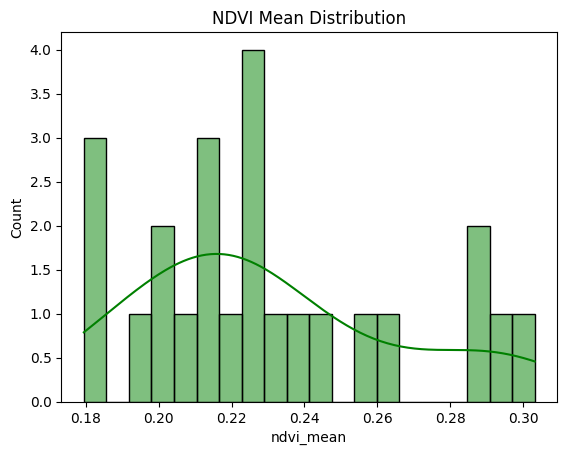

In [27]:
sns.histplot(df["ndvi_mean"], kde=True, bins=20, color="green")
plt.title("NDVI Mean Distribution")
plt.show()

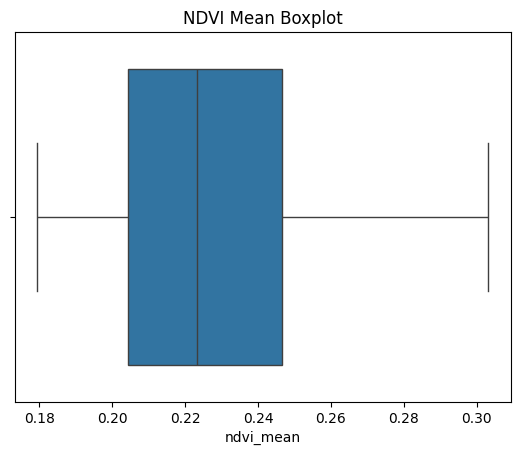

In [28]:
sns.boxplot(x=df["ndvi_mean"])
plt.title("NDVI Mean Boxplot")
plt.show()

### Time Series Plot

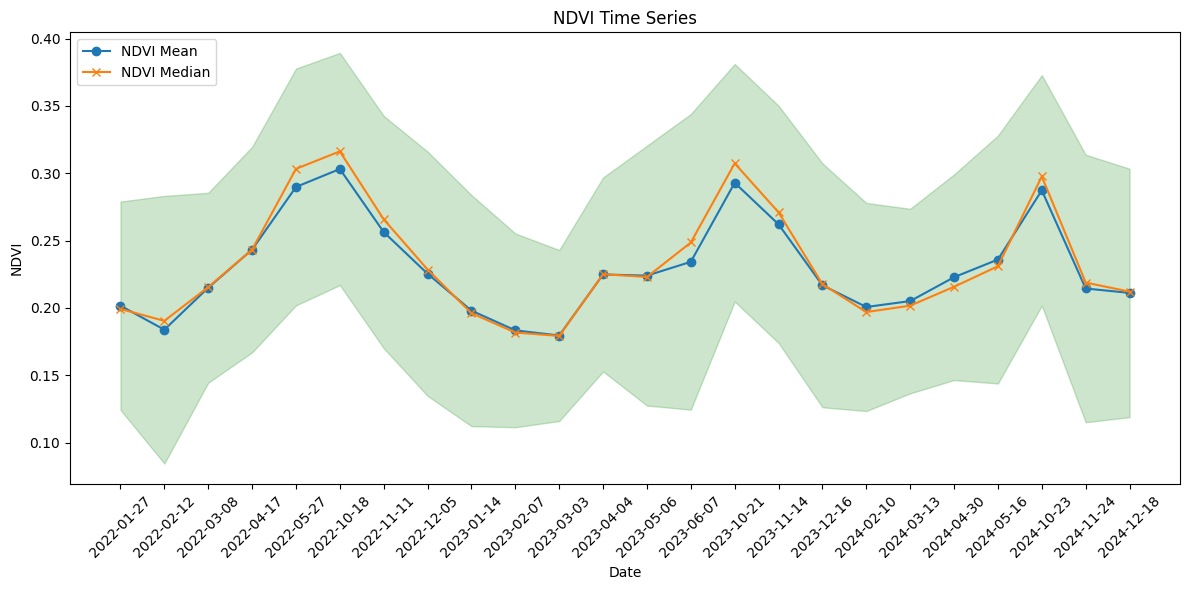

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["ndvi_mean"], marker="o", label="NDVI Mean")
plt.plot(df["date"], df["ndvi_median"], marker="x", label="NDVI Median")
plt.fill_between(
    df["date"],
    df["ndvi_mean"] - df["ndvi_std"],
    df["ndvi_mean"] + df["ndvi_std"],
    alpha=0.2,
    color="green",
)
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("NDVI Time Series")
plt.xticks(rotation=45)  # rotate x-axis labels
plt.legend()
plt.tight_layout()  # adjusts layout to prevent label cutoff
plt.show()

### Autocorrelation & Lag Analysis

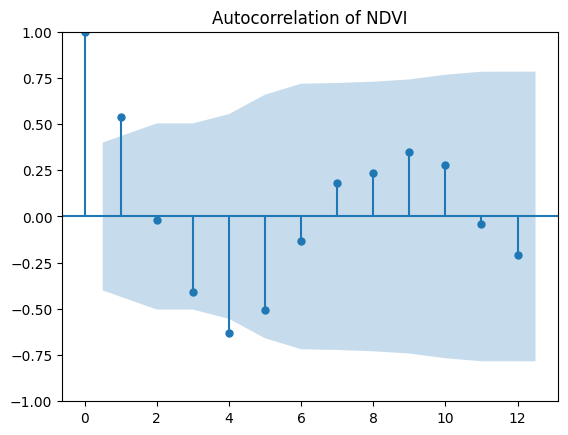

In [32]:
plot_acf(df["ndvi_mean"], lags=12)
plt.title("Autocorrelation of NDVI")
plt.show()

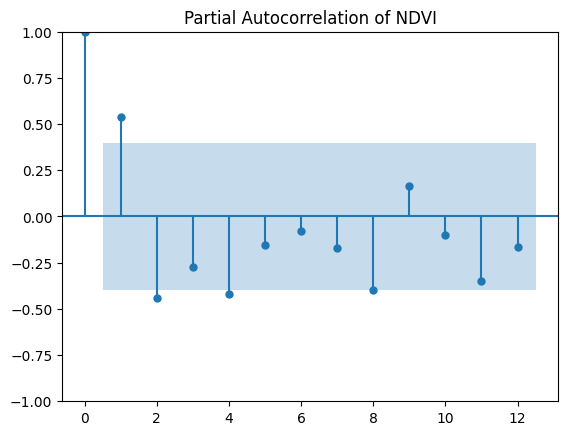

In [33]:
plot_pacf(df["ndvi_mean"], lags=12)
plt.title("Partial Autocorrelation of NDVI")
plt.show()

### Forecasting (Optional ARIMA Model)

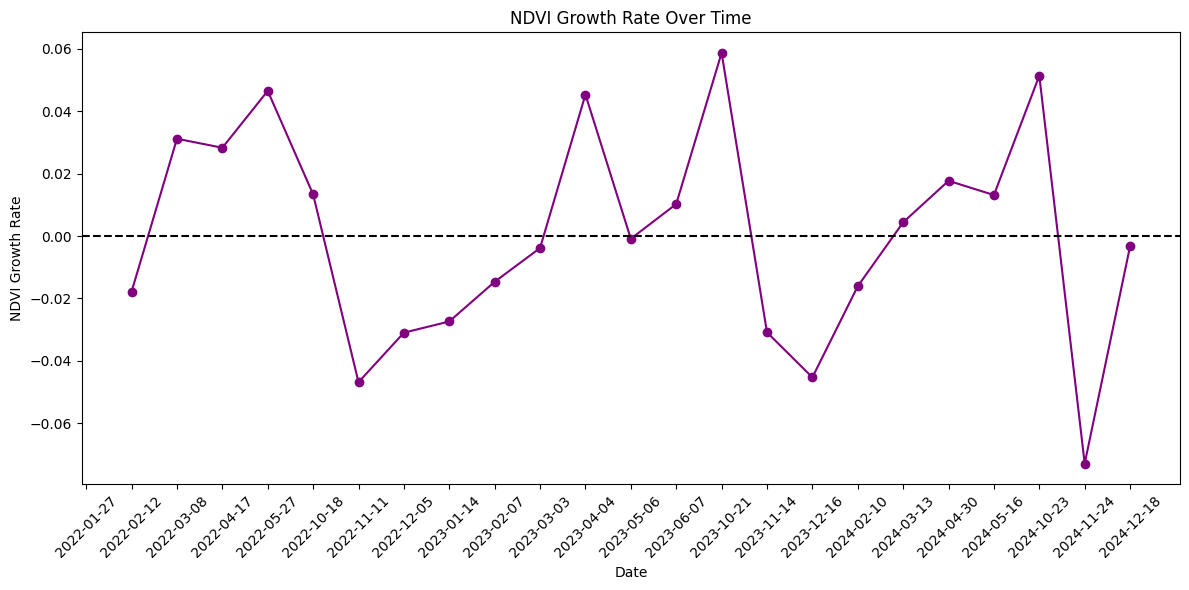

In [40]:
# Calculate NDVI growth rate (difference between consecutive NDVI values)
df["ndvi_growth"] = df["ndvi_mean"].diff()
# Plot NDVI growth rate
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["ndvi_growth"], marker="o", color="purple")
plt.axhline(0, color="black", linestyle="--")  # reference line at 0
plt.xlabel("Date")
plt.ylabel("NDVI Growth Rate")
plt.title("NDVI Growth Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Overall NDVI growth/decline percentage
ndvi_start = df["ndvi_mean"].iloc[0]  # first NDVI value
ndvi_end = df["ndvi_mean"].iloc[-1]  # last NDVI value

overall_change_pct = ((ndvi_end - ndvi_start) / ndvi_start) * 100
print(f"Overall NDVI change: {overall_change_pct:.2f}%")

Overall NDVI change: 4.72%


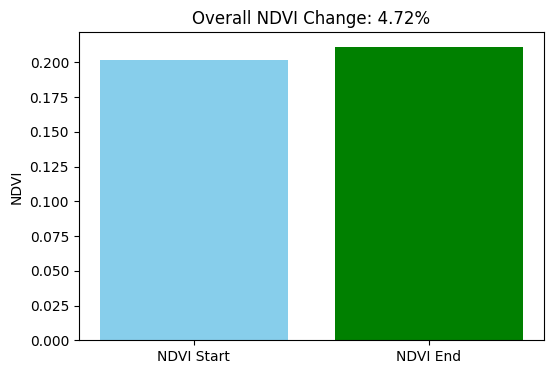

In [39]:
plt.figure(figsize=(6, 4))
plt.bar(["NDVI Start", "NDVI End"], [ndvi_start, ndvi_end], color=["skyblue", "green"])
plt.ylabel("NDVI")
plt.title(f"Overall NDVI Change: {overall_change_pct:.2f}%")
plt.show()